# Post-processing and figure plotting

## Figure sizing
AGU’s goal is for the text size of the labeling in each figure to match the text size in the body of the article. This means that for most AGU journals, text and labeling in a figure should be 8 points at the final printing size. Subscript and superscript should be 6 points.

All information within the figure, including symbols, legends, characters, patterns, and shading, must be legible at the final size. Figures should be sized between:

1/4 page figure = 95 mm x 115 mm
Full page = 190 mm x 230 mm

In [1]:
import numpy as np
import scipy.stats as st
import pandas as pd
import matplotlib.pyplot as pl
import os
import wquantiles
import matplotlib.gridspec as gridspec
import matplotlib.font_manager
from matplotlib import rc
from matplotlib.ticker import AutoMinorLocator
from matplotlib.lines import Line2D
from tqdm import tqdm_notebook
from netCDF4 import Dataset
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter

import h5py

In [2]:
def save_dict_to_hdf5(dic, filename):
    """
    ....
    """
    with h5py.File(filename, 'w') as h5file:
        recursively_save_dict_contents_to_group(h5file, '/', dic)

def recursively_save_dict_contents_to_group(h5file, path, dic):
    """
    ....
    """
    for key, item in dic.items():
        if isinstance(item, (np.ndarray, np.int64, np.float64, str, bytes)):
            h5file[path + key] = item
        elif isinstance(item, dict):
            recursively_save_dict_contents_to_group(h5file, path + key + '/', item)
        else:
            raise ValueError('Cannot save %s type'%type(item))

def load_dict_from_hdf5(filename):
    """
    ....
    """
    with h5py.File(filename, 'r') as h5file:
        return recursively_load_dict_contents_from_group(h5file, '/')

def recursively_load_dict_contents_from_group(h5file, path):
    """
    ....
    """
    ans = {}
    for key, item in h5file[path].items():
        if isinstance(item, h5py._hl.dataset.Dataset):
            ans[key] = item[()]
        elif isinstance(item, h5py._hl.group.Group):
            ans[key] = recursively_load_dict_contents_from_group(h5file, path + key + '/')
    return ans

In [3]:
pl.rcParams['figure.figsize'] = (12/2.54, 12/2.54)
pl.rcParams['font.size'] = 8
pl.rcParams['font.family'] = 'Arial'
pl.rcParams['xtick.direction'] = 'out'
pl.rcParams['xtick.minor.visible'] = True
pl.rcParams['ytick.minor.visible'] = True
pl.rcParams['ytick.right'] = True
pl.rcParams['xtick.top'] = True
pl.rcParams['figure.dpi'] = 96

In [4]:
nc = Dataset('../data_input/GCOS_all_heat_content_1960-2018_ZJ_v22062020.nc')
#print(nc.variables)
ohctop = nc.variables['ohc_0-2000m'][:]
ohcbot = nc.variables['ohc_below_2000m'][:]
atmosh = nc.variables['atmospheric_heat_content'][:]
cryosh = nc.variables['energy_cryosphere'][:]
landhc = nc.variables['ground_heat_content'][:]
ohctopu = nc.variables['ohc_0-2000m_uncertainty'][:]
ohcbotu = nc.variables['ohc_below_2000m_uncertainty'][:]
atmoshu = nc.variables['atmospheric_heat_content_uncertainty'][:]
cryoshu = nc.variables['energy_cryosphere_uncertainty'][:]
landhcu = nc.variables['ground_heat_content_uncertainty'][:]
nc.close()
cryosh[-1] = cryosh[-2]  # nan for 2017-2018, assume no change
cryoshu[-1] = cryoshu[-2]
OHCobs = (ohctop+ohcbot+atmosh+cryosh+landhc)-(ohctop+ohcbot+atmosh+cryosh+landhc)[11]
print(OHCobs[-1])
#OHCobs_u = np.sqrt(ohctopu**2 + ohcbotu**2 + atmoshu**2 + cryoshu**2 + landhcu**2)
#pl.fill_between(np.arange(1960.5, 2019), OHCobs - 2 * OHCobs_u, OHCobs + 2 * OHCobs_u, alpha=0.3)
#pl.plot(np.arange(1960.5,2019), OHCobs)

361.4982


In [5]:
# Model-specific ERF datasets
CanESM5_aerforcing = pd.read_csv('../data_output/rfmip_aprp/CanESM5.csv')
E3SM_aerforcing = pd.read_csv('../data_output/rfmip_aprp/E3SM.csv')
GISS_aerforcing = pd.read_csv('../data_output/rfmip_aprp/GISS-E2-1-G.csv')
HadGEM3_aerforcing = pd.read_csv('../data_output/rfmip_aprp/HadGEM3-GC31-LL.csv')
MIROC6_aerforcing = pd.read_csv('../data_output/rfmip_aprp/MIROC6.csv')
GFDL_aerforcing = pd.read_csv('../data_output/rfmip_aprp/GFDL-CM4.csv')
GFDLESM_aerforcing = pd.read_csv('../data_output/rfmip_aprp/GFDL-ESM4.csv')
NorESM2_aerforcing = pd.read_csv('../data_output/rfmip_aprp/NorESM2-LM.csv')
UKESM_aerforcing = pd.read_csv('../data_output/rfmip_aprp/UKESM1-0-LL.csv')
IPSL_aerforcing = pd.read_csv('../data_output/rfmip_aprp/IPSL-CM6A-LR.csv')
MRI_aerforcing = pd.read_csv('../data_output/rfmip_aprp/MRI-ESM2-0.csv')

# Lund et al., 2019, ACP: (details in supplement)
# https://www.atmos-chem-phys.net/19/13827/2019/acp-19-13827-2019-supplement.pdf
# we use SSP2-4.5 for extension
Lund_rfacipoints = [0, -0.03, -0.08, -0.12, -0.13, -0.15, -0.17, -0.21, -0.26, -0.33, -0.38, -0.37,
                    -0.40, -0.44, -0.40, -0.45, -0.44, -0.44, -0.42, -0.36, -0.35, -0.26, -0.11]
Lund_rfaripoints = [0, 0.002, -0.03, -0.05, -0.06, -0.06, -0.08, -0.10, -0.14, -0.24, -0.26, -0.24,
                    -0.24, -0.22, -0.19, -0.20, -0.17, -0.17, -0.13, -0.10, -0.13, -0.09, -0.09]
Lund_timepoints  = [1750, 1850, 1900, 1910, 1920, 1930, 1940, 1950, 1960, 1970, 1980, 1985, 1990, 1995,
                    2000, 2005, 2010, 2014, 2015, 2020, 2030, 2050, 2100]
f = interp1d(Lund_timepoints, np.array(Lund_rfacipoints)+np.array(Lund_rfaripoints))
Lund_aerforcing = f(np.arange(1750,2101))
f = interp1d(Lund_timepoints, np.array(Lund_rfaripoints))
Lund_ERFari = f(np.arange(1750,2101))
f = interp1d(Lund_timepoints, np.array(Lund_rfacipoints))
Lund_ERFaci = f(np.arange(1750,2101))

In [6]:
cw_temp = np.loadtxt('../data_input/CW.txt')

-0.0005179520184544435
1.0972445294117645


170

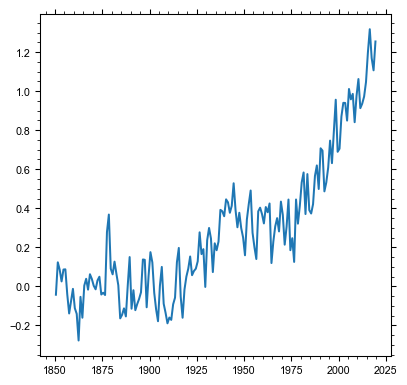

In [7]:
blratio = np.loadtxt('../data_input/cmip5_data_2019.txt')[5,:]
cowtan = cw_temp[:,1] - np.mean(cw_temp[:51,1])
years  = cw_temp[:,0]+0.5
blratio  = np.concatenate((np.ones(11), blratio))
Tobs = blratio * cowtan
pl.plot(years, Tobs)
#pl.plot(np.arange(1750,1901), best_land)
print(np.mean(Tobs[:51]))
print(np.mean(Tobs[160:170]))
#print(blratio)
len(Tobs)

In [8]:
models = ['CanESM5','E3SM','GFDL-CM4','GFDL-ESM4','GISS-E2-1-G','HadGEM3-GC31-LL','IPSL-CM6A-LR','MIROC6','MRI-ESM2-0','NorESM2-LM','UKESM1-0-LL']

colors = {
    'CMIP6-constrained' : '0.3',
    'CanESM5'        : 'red',#'#1e4c24',
    'E3SM'           : 'darkorange',
    'GFDL-ESM4'      : 'yellowgreen', 
    'GFDL-CM4'       : 'yellow',#'green',
    'GISS-E2-1-G'    : 'green',#'#771d7b',
    'HadGEM3-GC31-LL': 'turquoise',
    'IPSL-CM6A-LR'   : 'teal',
    'MIROC6'         : 'blue',#b85fb7',
    'MRI-ESM2-0'     : 'blueviolet',
    'NorESM2-LM'     : 'purple',#'red',
    'UKESM1-0-LL'    : 'crimson',
    'observations'   : 'black',
    'Oslo-CTM3'      : 'pink',
}

ls = {
    'CMIP6-constrained'  : '-',
    'CanESM5'        : '-',
    'E3SM'           : '-',
    'GFDL-ESM4'      : '-',
    'GFDL-CM4'       : '-',
    'GISS-E2-1-G'    : '-',
    'HadGEM3-GC31-LL': '-',
    'IPSL-CM6A-LR'   : '-',
    'MIROC6'         : '-',
    'MRI-ESM2-0'     : '-',
    'NorESM2-LM'     : '-',
    'UKESM1-0-LL'    : '-',
    'Oslo-CTM3'      : '-',
    'observations'   : '-',
}

In [9]:
# load large datafiles calculated previously
ERFari = load_dict_from_hdf5('../data_output/results/ERFari.h5')
ERFaci = load_dict_from_hdf5('../data_output/results/ERFaci.h5')
temp   = load_dict_from_hdf5('../data_output/results/temp.h5')
ks     = load_dict_from_hdf5('../data_output/results/knutti_score.h5')
ohc    = load_dict_from_hdf5('../data_output/results/ohc.h5')
hflux  = load_dict_from_hdf5('../data_output/results/hflux.h5')

In [10]:
pc = load_dict_from_hdf5('../data_output/results/pc.h5')

In [11]:
intvar = np.loadtxt('../data_output/piControl/internal_variability_piControl.txt')

In [12]:
expts = ['CMIP6-constrained','CanESM5','E3SM','GFDL-CM4','GFDL-ESM4','GISS-E2-1-G','HadGEM3-GC31-LL','IPSL-CM6A-LR','MIROC6','MRI-ESM2-0','NorESM2-LM','Oslo-CTM3','UKESM1-0-LL']

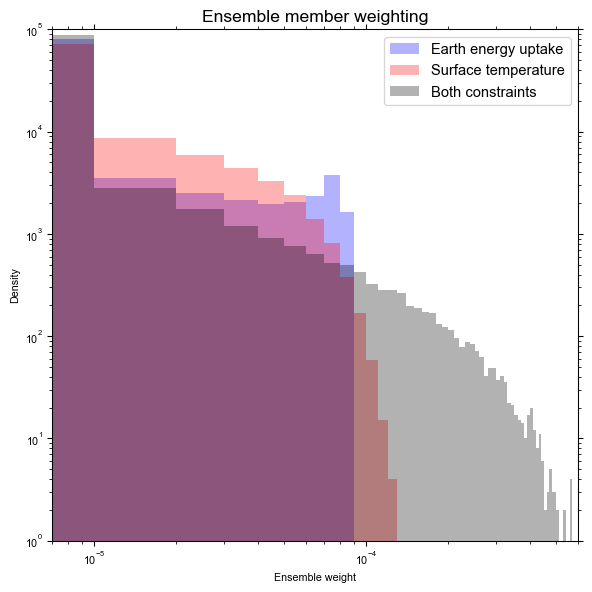

In [13]:
fig, ax = pl.subplots(figsize=(16/2.54, 16/2.54))
pl.rcParams['font.size'] = 11
ax.hist(ks['ohc']['CMIP6-constrained'], alpha=.3, bins=np.arange(0,0.002,0.00001), color='blue', label='Earth energy uptake', density=True, histtype='stepfilled')
ax.hist(ks['temp']['CMIP6-constrained'], alpha=.3, bins=np.arange(0,0.002,0.00001), color='red', label='Surface temperature', density=True, histtype='stepfilled')
ax.hist(ks['multi']['CMIP6-constrained'], alpha=.3, bins=np.arange(0,0.002,0.00001), color='black', label='Both constraints', density=True, histtype='stepfilled')
ax.legend()
ax.set_ylabel('Density')
ax.set_xlabel('Ensemble weight')
pl.yscale('log')
pl.xscale('log')
ax.set_ylim(1,100000)
ax.set_xlim(7e-6,6e-4)
ax.set_title('Ensemble member weighting')
fig.tight_layout()
pl.savefig('../figures/figureS6.png', dpi=300)
pl.savefig('../figures/figureS6.pdf')
#pl.xlim(0,0.002)
#pl.ylim(0,1000)

In [14]:
pl.rcParams['font.size'] = 8

(-50.0, 400.0)

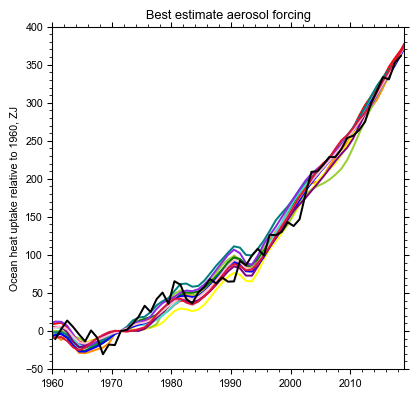

In [15]:
fig, ax = pl.subplots()
for expt in expts:
    ax.plot(np.arange(1750.5,2020), 10*np.nansum((ohc[expt]-ohc[expt][221,:])*ks['multi'][expt], axis=1), color=colors[expt])
ax.set_title('Best estimate aerosol forcing')
ax.set_ylabel('Ocean heat uptake relative to 1960, ZJ')
ax.plot(np.arange(1960.5,2019), (OHCobs-OHCobs[11]), color=colors['observations'])
ax.set_xlim(1960,2019)
ax.set_ylim(-50,400)

In [16]:
samples = 100000
geoff_sample_df = pd.read_csv('../data_output/geoff_sample.csv')
geoff_sample_df

,q4x,lamg,cmix,cdeep,gamma_2l,eff
0,8.569671,0.946054,7.620429,99.241167,0.518900,1.283281
1,7.890972,0.827534,8.153162,82.939913,0.442718,0.945874
2,6.341833,1.451968,7.713740,28.002160,0.566080,1.363958
3,8.550127,1.005517,8.350768,95.452195,0.764217,1.482855
4,8.015175,1.031315,7.725848,106.037790,0.980565,1.425992
...,...,...,...,...,...,...
99995,6.715211,0.278028,8.654595,68.442055,0.495821,1.038330
99996,6.025860,0.228633,8.673851,48.009633,0.512303,1.683357
99997,6.158970,0.416565,10.606037,107.798188,0.482221,1.728365
99998,10.629554,2.107970,6.416861,139.542078,0.935036,1.850492


In [17]:
# Throw TCR into the mix: Jimenez-de-la-Cuesta and Mauritsen (2019) estimate from two layer parameters
tcr = geoff_sample_df['q4x'][:samples]/2/(geoff_sample_df[:samples]['lamg'] + geoff_sample_df[:samples]['eff']*geoff_sample_df[:samples]['gamma_2l'])
ecs = geoff_sample_df['q4x'][:samples]/2/(geoff_sample_df[:samples]['lamg'])

In [18]:
for constraint in ['temp','ohc','multi']:
    print(constraint)
    print('---------')
    for expt in expts:
        print(expt, constraint, 'ECS', '%4.2f %4.2f %4.2f %4.2f %4.2f %4.2f' % (pc[expt][constraint]['ECS']['5'], pc[expt][constraint]['ECS']['16'], pc[expt][constraint]['ECS']['50'], np.sum(ecs*ks[constraint][expt]), pc[expt][constraint]['ECS']['84'], pc[expt][constraint]['ECS']['95']))
        print(expt, constraint, 'TCR', '%4.2f %4.2f %4.2f %4.2f %4.2f %4.2f' % (pc[expt][constraint]['TCR']['5'], pc[expt][constraint]['TCR']['16'], pc[expt][constraint]['TCR']['50'], np.sum(tcr*ks[constraint][expt]), pc[expt][constraint]['TCR']['84'], pc[expt][constraint]['TCR']['95']))
        print(expt, constraint, 'ERFaer', '%4.2f %4.2f %4.2f %4.2f %4.2f %4.2f' % (pc[expt][constraint]['ERFaer']['5'][269], pc[expt][constraint]['ERFaer']['16'][269], pc[expt][constraint]['ERFaer']['50'][269], np.sum((ERFari[expt][269] + ERFaci[expt][269])*ks[constraint][expt]), pc[expt][constraint]['ERFaer']['84'][269], pc[expt][constraint]['ERFaer']['95'][269]))
        print(expt, constraint, 'ERFari', '%4.2f %4.2f %4.2f %4.2f %4.2f %4.2f' % (pc[expt][constraint]['ERFari']['5'][269], pc[expt][constraint]['ERFari']['16'][269], pc[expt][constraint]['ERFari']['50'][269], np.sum(ERFari[expt][269]*ks[constraint][expt]), pc[expt][constraint]['ERFari']['84'][269], pc[expt][constraint]['ERFari']['95'][269]))
        print(expt, constraint, 'ERFaci', '%4.2f %4.2f %4.2f %4.2f %4.2f %4.2f' % (pc[expt][constraint]['ERFaci']['5'][269], pc[expt][constraint]['ERFaci']['16'][269], pc[expt][constraint]['ERFaci']['50'][269], np.sum(ERFaci[expt][269]*ks[constraint][expt]), pc[expt][constraint]['ERFaci']['84'][269], pc[expt][constraint]['ERFaci']['95'][269]))

temp
---------
CMIP6-constrained temp ECS 1.93 2.34 3.08 3.39 4.36 5.84
CMIP6-constrained temp TCR 1.33 1.53 1.84 1.89 2.25 2.60
CMIP6-constrained temp ERFaer -1.43 -1.14 -0.77 -0.80 -0.45 -0.28
CMIP6-constrained temp ERFari -0.59 -0.44 -0.27 -0.29 -0.13 -0.06
CMIP6-constrained temp ERFaci -1.08 -0.82 -0.48 -0.51 -0.21 -0.05
CanESM5 temp ECS 1.89 2.29 2.96 3.22 4.06 5.35
CanESM5 temp TCR 1.31 1.50 1.79 1.82 2.15 2.44
CanESM5 temp ERFaer -0.83 -0.59 -0.25 -0.29 -0.00 0.14
CanESM5 temp ERFari 0.05 0.07 0.13 0.13 0.18 0.22
CanESM5 temp ERFaci -0.93 -0.70 -0.38 -0.42 -0.15 -0.02
E3SM temp ECS 1.92 2.33 3.06 3.38 4.33 5.84
E3SM temp TCR 1.33 1.53 1.84 1.89 2.25 2.60
E3SM temp ERFaer -1.22 -1.04 -0.76 -0.77 -0.49 -0.34
E3SM temp ERFari -0.57 -0.46 -0.31 -0.33 -0.19 -0.12
E3SM temp ERFaci -0.87 -0.69 -0.43 -0.44 -0.19 -0.07
GFDL-CM4 temp ECS 1.92 2.33 3.04 3.34 4.27 5.65
GFDL-CM4 temp TCR 1.33 1.53 1.83 1.87 2.21 2.52
GFDL-CM4 temp ERFaer -1.01 -0.80 -0.52 -0.54 -0.28 -0.15
GFDL-CM4 temp ERFa

In [19]:
np.sum(ecs*ks['multi']['CMIP6-constrained'])

3.101400420586319

In [20]:
np.sum(tcr*ks['multi']['CMIP6-constrained'])

1.8333514131165973

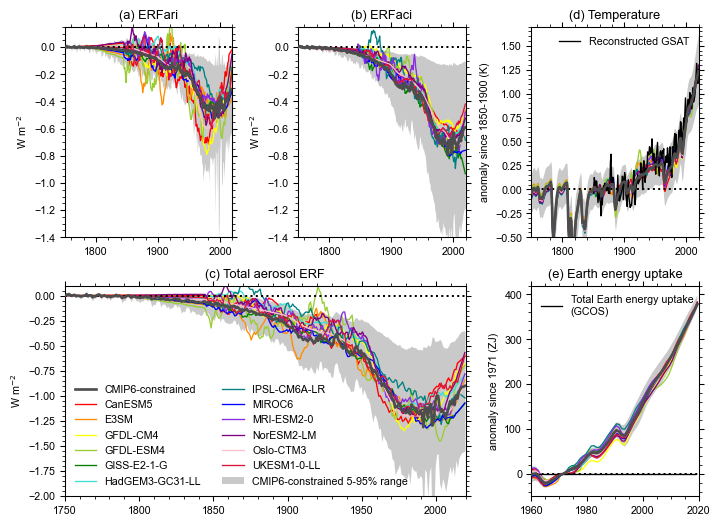

In [21]:
matplotlib.font_manager._rebuild()

#fig, ax = pl.subplots(3,2,figsize=(16/2.54,23/2.54))
fig = pl.figure(figsize=(19/2.54,14/2.54))
gs = gridspec.GridSpec(ncols=6, nrows=2)
axtmp = fig.add_subplot(gs[0,4:6])
axohc = fig.add_subplot(gs[1,4:6])
axari = fig.add_subplot(gs[0,0:2])
axaci = fig.add_subplot(gs[0,2:4])
axaer = fig.add_subplot(gs[1,0:4])

expt='CMIP6-constrained'
axtmp.fill_between(np.arange(1750.5,2020), pc[expt]['multi']['GSAT']['5'], pc[expt]['multi']['GSAT']['95'], color=colors[expt], alpha=0.3, lw=0)
axaer.fill_between(np.arange(1750.5,2020), pc[expt]['multi']['ERFaer']['5'], pc[expt]['multi']['ERFaer']['95'], color=colors[expt], alpha=0.3, lw=0, label='CMIP6-constrained 5-95% range')
axari.fill_between(np.arange(1750.5,2020), pc[expt]['multi']['ERFari']['5'], pc[expt]['multi']['ERFari']['95'], color=colors[expt], alpha=0.3, lw=0)
axaci.fill_between(np.arange(1750.5,2020), pc[expt]['multi']['ERFaci']['5'], pc[expt]['multi']['ERFaci']['95'], color=colors[expt], alpha=0.3, lw=0)
axohc.fill_between(np.arange(1750.5,2020), 10*(pc[expt]['multi']['OHC']['5']-pc[expt]['multi']['OHC']['5'][221]), 10*(pc[expt]['multi']['OHC']['95']-pc[expt]['multi']['OHC']['95'][221]), color=colors[expt], alpha=0.3, lw=0)

for expt in expts:
    if expt=='CMIP6-constrained':
        lw=2
        zorder=10
        axtmp.plot(np.arange(1750.5,2020), np.nansum((temp[expt] + intvar[:,:samples])*ks['multi'][expt], axis=1), lw=lw, ls=ls[expt], color=colors[expt], zorder=zorder)
        axaer.plot(np.arange(1750.5,2020), np.nansum((ERFari[expt][:270]+ERFaci[expt][:270])*ks['multi'][expt], axis=1), lw=lw, ls=ls[expt], label=expt, color=colors[expt], zorder=zorder)
        axari.plot(np.arange(1750.5,2020), np.nansum((ERFari[expt][:270])*ks['multi'][expt], axis=1), lw=lw, ls=ls[expt], label=expt, color=colors[expt], zorder=zorder)
        axaci.plot(np.arange(1750.5,2020), np.nansum((ERFaci[expt][:270])*ks['multi'][expt], axis=1), lw=lw, ls=ls[expt], label=expt, color=colors[expt], zorder=zorder)
        axohc.plot(np.arange(1750.5,2020), 10*np.nansum((ohc[expt]-ohc[expt][221,:])*ks['multi'][expt], axis=1), lw=lw, ls=ls[expt], color=colors[expt], zorder=zorder)

    else:
        lw=1
        zorder=1
        axtmp.plot(np.arange(1750.5,2020), np.nansum((temp[expt] + intvar[:,:samples])*ks['multi'][expt], axis=1), lw=lw, ls=ls[expt], color=colors[expt], zorder=zorder)
        axaer.plot(np.arange(1750.5,2020), savgol_filter(np.nansum((ERFari[expt][:270]+ERFaci[expt][:270])*ks['multi'][expt], axis=1), 11, 1), lw=lw, ls=ls[expt], label=expt, color=colors[expt], zorder=zorder)
        axari.plot(np.arange(1750.5,2020), savgol_filter(np.nansum((ERFari[expt][:270])*ks['multi'][expt], axis=1), 11, 1), lw=lw, ls=ls[expt], label=expt, color=colors[expt], zorder=zorder)
        axaci.plot(np.arange(1750.5,2020), savgol_filter(np.nansum((ERFaci[expt][:270])*ks['multi'][expt], axis=1), 11, 1), lw=lw, ls=ls[expt], label=expt, color=colors[expt], zorder=zorder)
        axohc.plot(np.arange(1750.5,2020), 10*np.nansum((ohc[expt]-ohc[expt][221,:])*ks['multi'][expt], axis=1), lw=lw, ls=ls[expt], color=colors[expt], zorder=zorder)

axtmp.plot(years, Tobs, color=colors['observations'], label='Reconstructed GSAT', lw=1)
axohc.plot(np.arange(1960.5,2019), (OHCobs-OHCobs[11])/1e21, color=colors['observations'], lw=1, label='Total Earth energy uptake\n(GCOS)')
axtmp.legend(frameon=False)
axohc.legend(frameon=False, loc='upper left')
axtmp.set_xlim(1750,2020)
axtmp.set_ylim(-0.5,1.7)
axtmp.set_ylabel('anomaly since 1850-1900 (K)');
axtmp.set_title('(d) Temperature')
axtmp.axhline(0, ls=':', color='k')
axohc.axhline(0, ls=':', color='k')
axohc.set_ylabel('anomaly since 1971 (ZJ)')
axohc.set_title('(e) Earth energy uptake')
axohc.set_ylim(-50,420)
axohc.set_xlim(1960,2020)
axaer.set_xlim(1750,2020)
axaer.set_ylim(-2.0,0.1)
axaer.set_ylabel('W m$^{-2}$');
axaer.set_title('(c) Total aerosol ERF')
axaer.axhline(0, ls=':', color='k')
axaer.legend(fontsize=8, frameon=False, ncol=2);
axari.set_xlim(1750,2020)
axari.set_ylim(-1.4,0.15)
axari.set_ylabel('W m$^{-2}$');
axari.set_title('(a) ERFari')
axari.axhline(0, ls=':', color='k')
axaci.set_xlim(1750,2020)
axaci.set_ylim(-1.4,0.15)
axaci.set_ylabel('W m$^{-2}$');
axaci.set_title('(b) ERFaci')
axaci.axhline(0, ls=':', color='k')
fig.tight_layout()
pl.savefig('../figures/figure6.png', dpi=300)
pl.savefig('../figures/figure6.pdf')

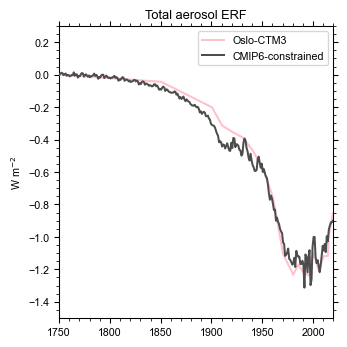

In [22]:
# This figure is visual evidence that the emulator does a good job of getting the aerosol forcing compared to a CTM
# the correspondence used to be very, very good; since I used the updated CEDS emissions with a revision to the SO2 in the
# early 20th century and early 21st century (fig S2) the correspondence is less good, but this is down to the fact that 
# OsloCTM3 was run with the older CMIP6 emissions.
fig, ax = pl.subplots(figsize=(9.3/2.54,9.3/2.54))
ax.plot(np.arange(1750.5,2020), np.nansum((ERFari['Oslo-CTM3'][:270]+ERFaci['Oslo-CTM3'][:270])*ks['multi']['Oslo-CTM3'], axis=1), label='Oslo-CTM3', color=colors['Oslo-CTM3'], zorder=5)
ax.plot(np.arange(1750.5,2020), np.nansum((ERFari['CMIP6-constrained'][:270]+ERFaci['CMIP6-constrained'][:270])*ks['multi']['CMIP6-constrained'], axis=1), label='CMIP6-constrained', color=colors['CMIP6-constrained'], zorder=5)

ax.legend()
ax.set_xlim(1750,2020)
ax.set_ylim(-1.5,0.3)
ax.set_title('Total aerosol ERF')
ax.set_ylabel('W m$^{-2}$')
fig.tight_layout()

In [23]:
year = np.arange(1750,2020)
erfaer = np.nansum((ERFari['CMIP6-constrained'][:270]+ERFaci['CMIP6-constrained'][:270])*ks['multi']['CMIP6-constrained'], axis=1)
erfaer05 = pc['CMIP6-constrained']['multi']['ERFaer']['5']
erfaer16 = pc['CMIP6-constrained']['multi']['ERFaer']['16']
erfaer50 = pc['CMIP6-constrained']['multi']['ERFaer']['50']
erfaer84 = pc['CMIP6-constrained']['multi']['ERFaer']['84']
erfaer95 = pc['CMIP6-constrained']['multi']['ERFaer']['95']
df = pd.DataFrame(data=np.array([year, erfaer05, erfaer16, erfaer, erfaer50, erfaer84, erfaer95]).T, columns =['year','pc05','pc16','mean','pc50','pc84','pc95'])
df = df.astype({'year':int})
df.set_index('year', inplace=True)
df.to_csv('../data_output/aerosol_forcing.csv')

In [24]:
erfaer[230:265].mean()

-1.130618205177522

In [25]:
erfaer05[269],erfaer16[269],erfaer[269],erfaer84[269],erfaer95[269]

(-1.5458678687471548,
 -1.2633682722784245,
 -0.9011199478759985,
 -0.5428478022838173,
 -0.3528943234993417)

In [26]:
erfaer05[255:265].mean(),erfaer16[255:265].mean(),erfaer[255:265].mean(),erfaer84[255:265].mean(),erfaer95[255:265].mean()

(-1.782718906728558,
 -1.500073396958337,
 -1.0982345423977131,
 -0.7035291843600452,
 -0.47534563793162843)

In [27]:
erfaer05[269]-erfaer05[100],erfaer16[269]-erfaer16[100],erfaer[269]-erfaer[100],erfaer84[269]-erfaer84[100],erfaer95[269]-erfaer95[100]

(-1.2964897540464517,
 -1.0952110275517222,
 -0.8077417768055931,
 -0.5196380453540278,
 -0.375997363597883)

In [28]:
erfaer05[255:265].mean()-erfaer05[100],erfaer16[255:265].mean()-erfaer16[100],erfaer[255:265].mean()-erfaer[100],erfaer84[255:265].mean()-erfaer84[100],erfaer95[255:265].mean()--erfaer95[100]

(-1.5333407920278552,
 -1.3319161522316345,
 -1.0048563713273078,
 -0.6803194274302556,
 -0.4522425978330871)

In [29]:
erfari = np.nansum((ERFari['CMIP6-constrained'][:270])*ks['multi']['CMIP6-constrained'], axis=1)
erfari05 = pc['CMIP6-constrained']['multi']['ERFari']['5']
erfari16 = pc['CMIP6-constrained']['multi']['ERFari']['16']
erfari50 = pc['CMIP6-constrained']['multi']['ERFari']['50']
erfari84 = pc['CMIP6-constrained']['multi']['ERFari']['84']
erfari95 = pc['CMIP6-constrained']['multi']['ERFari']['95']

In [30]:
erfari05[269],erfari16[269],erfari[269],erfari84[269],erfari95[269]

(-0.6244327746336447,
 -0.46515577154402304,
 -0.310041896370096,
 -0.14684704150651412,
 -0.0789444459167335)

In [31]:
erfari05[255:265].mean(),erfari16[255:265].mean(),erfari[255:265].mean(),erfari84[255:265].mean(),erfari95[255:265].mean()

(-0.766143225277342,
 -0.5909534212521645,
 -0.4043890302738424,
 -0.2119459474053284,
 -0.12422504128411316)

In [32]:
erfari05[269]-erfari05[100],erfari16[269]-erfari16[100],erfari[269]-erfari[100],erfari84[269]-erfari84[100],erfari95[269]-erfari95[100]

(-0.4564377687631156,
 -0.38316781996408417,
 -0.27849092000222725,
 -0.16440215949169204,
 -0.14689675920193523)

In [33]:
erfari05[255:265].mean()-erfari05[100],erfari16[255:265].mean()-erfari16[100],erfari[255:265].mean()-erfari[100],erfari84[255:265].mean()-erfari84[100],erfari95[255:265].mean()--erfari95[100]

(-0.598148219406813,
 -0.5089654696722257,
 -0.37283805390597363,
 -0.22950106539050633,
 -0.05627272799891142)

In [34]:
erfaci = np.nansum((ERFaci['CMIP6-constrained'][:270])*ks['multi']['CMIP6-constrained'], axis=1)
erfaci05 = pc['CMIP6-constrained']['multi']['ERFaci']['5']
erfaci16 = pc['CMIP6-constrained']['multi']['ERFaci']['16']
erfaci50 = pc['CMIP6-constrained']['multi']['ERFaci']['50']
erfaci84 = pc['CMIP6-constrained']['multi']['ERFaci']['84']
erfaci95 = pc['CMIP6-constrained']['multi']['ERFaci']['95']

In [35]:
erfaci05[269],erfaci16[269],erfaci[269],erfaci84[269],erfaci95[269]

(-1.1809879262368397,
 -0.925650902887968,
 -0.5910780515059024,
 -0.26311251493406146,
 -0.10285817092955969)

In [36]:
erfaci05[255:265].mean(),erfaci16[255:265].mean(),erfaci[255:265].mean(),erfaci84[255:265].mean(),erfaci95[255:265].mean()

(-1.3640179855877874,
 -1.08221444573882,
 -0.6938455121238707,
 -0.31221638846614874,
 -0.12255665201108237)

In [37]:
erfaci05[269]-erfaci05[100],erfaci16[269]-erfaci16[100],erfaci[269]-erfaci[100],erfaci84[269]-erfaci84[100],erfaci95[269]-erfaci95[100]

(-1.023721234405632,
 -0.8211138295895453,
 -0.5292508568033658,
 -0.243275549754928,
 -0.0954224855366469)

In [38]:
erfaci05[255:265].mean()-erfaci05[100],erfaci16[255:265].mean()-erfaci16[100],erfaci[255:265].mean()-erfaci[100],erfaci84[255:265].mean()-erfaci84[100],erfaci95[255:265].mean()--erfaci95[100]

(-1.2067512937565796,
 -0.9776773724403973,
 -0.6320183174213341,
 -0.29237942328701527,
 -0.12999233740399518)

In [39]:
erfaci05[269],erfaci[269],erfaci95[269]

(-1.1809879262368397, -0.5910780515059024, -0.10285817092955969)

In [40]:
# Use Nicolas' Ringberg methods, from script provided to me
def uniform1684(a,b,seed,samples=2000):
    interval = (b-a)+((b-a)/(84-16)*32)
    lower = a-((b-a)/(84-16)*16)
    return st.uniform.rvs(lower, interval, size=samples, random_state=seed)

dtau    = uniform1684(0.02,0.04,123,samples=samples)
tau     = uniform1684(0.13,0.17,124,samples=samples)
S_tau   = uniform1684(-27,-20,125,samples=samples)
RFari_cloudy = uniform1684(-0.1,0.1,126,samples=samples)
dR_dRatm = uniform1684(-0.3,-0.1,127,samples=samples)
dRatm_dtau = uniform1684(17,35,128,samples=samples)
c_tau    = uniform1684(0.59,0.71,129,samples=samples)
c_N      = uniform1684(0.19,0.29,130,samples=samples)
c_L      = uniform1684(0.21,0.29,131,samples=samples)
c_C      = uniform1684(0.59,1.07,132,samples=samples)
beta_N_tau = uniform1684(0.3,0.8,133,samples=samples)
beta_L_N   = uniform1684(-0.36,-0.011,134,samples=samples)
beta_C_N   = uniform1684(0,0.1,135,samples=samples)
S_N = uniform1684(-27,-26,136,samples=samples)
S_L = uniform1684(-56,-54,137,samples=samples)
S_C = uniform1684(-153,-91,138,samples=samples)

rfari = dtau*S_tau*(1-c_tau)+RFari_cloudy
rfari_adj = dtau*dR_dRatm*dRatm_dtau

dlntau = dtau/tau
deltan = dlntau * beta_N_tau

rfaci = dlntau*beta_N_tau*S_N*c_N
erfaci_L = dlntau*beta_N_tau*beta_L_N*S_L*c_L
erfaci_C = dlntau*beta_N_tau*beta_C_N*S_C*c_C

ERFari_scale = rfari + rfari_adj
ERFaci_scale = rfaci + erfaci_L + erfaci_C

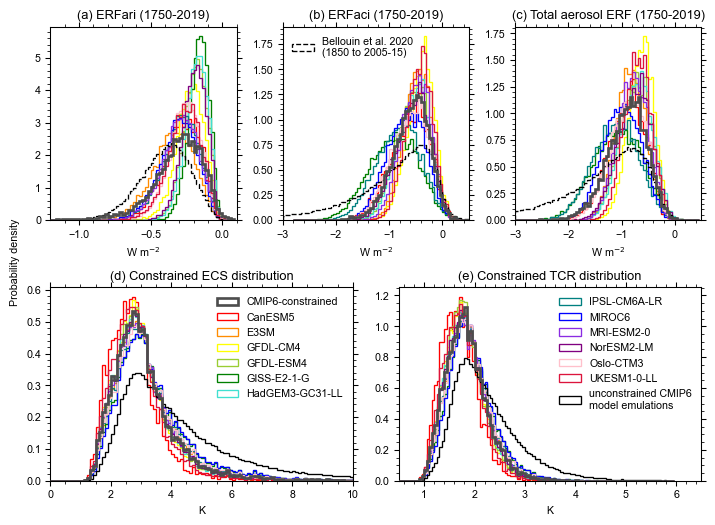

In [41]:
fig = pl.figure(figsize=(19/2.54,14/2.54))
gs = gridspec.GridSpec(ncols=6, nrows=2)
axecs = fig.add_subplot(gs[1,0:3])
axtcr = fig.add_subplot(gs[1,3:6])
axari = fig.add_subplot(gs[0,0:2])
axaci = fig.add_subplot(gs[0,2:4])
axaer = fig.add_subplot(gs[0,4:6])
histtype='step'
for i, expt in enumerate(expts):
    if expt=='CMIP6-constrained':
        zorder=10
        lw=2
    else:
        zorder=1
        lw=1
    if i<7:
        label1=expt
        label2=''
    else:
        label1=''
        label2=expt
    axari.hist(ERFari[expt][268,:], weights=ks['multi'][expt], bins=np.arange(-1.2,0.1,0.02), color=colors[expt], histtype=histtype, edgecolor=colors[expt], lw=lw, density=True, zorder=zorder);
    axaci.hist(ERFaci[expt][268,:], weights=ks['multi'][expt], bins=np.arange(-2.8,0.85,0.05), color=colors[expt], histtype=histtype, edgecolor=colors[expt], lw=lw, density=True, zorder=zorder);
    axaer.hist(ERFari[expt][268,:]+ERFaci[expt][268,:], weights=ks['multi'][expt], bins=np.arange(-3,0.5,0.05), color=colors[expt], histtype='step', edgecolor=colors[expt], lw=lw, density=True, zorder=zorder);
    axecs.hist(geoff_sample_df['q4x'][:samples]/2/(geoff_sample_df[:samples]['lamg']), weights=ks['multi'][expt], bins=np.arange(0,10.1,0.1), color=colors[expt], histtype=histtype, edgecolor=colors[expt], lw=lw, density=True, zorder=zorder, label=label1);
    axtcr.hist(tcr[:samples], weights=ks['multi'][expt][:samples], bins=np.arange(0,6,0.05), color=colors[expt], histtype=histtype, edgecolor=colors[expt], lw=lw, density=True, label=label2, zorder=zorder)
axari.hist(ERFari_scale, bins=np.arange(-1.2,0.1,0.02), color='k', histtype='step', edgecolor='k', lw=1, ls='--', density=True, label='Bellouin et al. 2020\n(1850 to 2005-15)');
axari.set_title('(a) ERFari (1750-2019)');
axari.set_xlabel('W m$^{-2}$')
axari.set_xlim(-1.2,0.1);
axaci.hist(ERFaci_scale, bins=np.arange(-3,0.85,0.05), color='k', histtype='step', edgecolor='k', lw=1, ls='--', density=True, label='Bellouin et al. 2020\n(1850 to 2005-15)');
axaci.set_title('(b) ERFaci (1750-2019)');
axaci.set_xlabel('W m$^{-2}$')
axaci.set_xlim(-3,0.5);
axaci.legend(loc='upper left', frameon=False);
axaer.hist(ERFari_scale+ERFaci_scale, bins=np.arange(-3,0.55,0.05), color='k', histtype='step', edgecolor='k', lw=1, ls='--', density=True, label='prior');
axaer.set_title('(c) Total aerosol ERF (1750-2019)');
axaer.set_xlabel('W m$^{-2}$')
axaer.set_xlim(-3,0.5);
axecs.hist(geoff_sample_df['q4x'][:samples]/2/(geoff_sample_df[:samples]['lamg']), bins=np.arange(0,10.1,0.1), color='k', histtype='step', edgecolor='k', lw=1, density=True);
axecs.set_title('(d) Constrained ECS distribution');
axecs.set_xlabel('K')
axecs.set_xlim(0,10)
axtcr.hist(tcr[:samples], bins=np.arange(0,6,0.05), color='k', histtype='step', edgecolor='k', lw=1, density=True, label='unconstrained CMIP6\nmodel emulations');
axtcr.set_title('(e) Constrained TCR distribution');
axtcr.set_xlabel('K')
axecs.legend(fontsize=8, frameon=False)
axtcr.legend(fontsize=8, frameon=False)
axtcr.set_xlim(0.5,6.5)
#ax.set_ylabel('Probability density')
pl.figtext(0.015,0.5,'Probability density', rotation=90, va='center', ha='center')

fig.tight_layout(rect=[0.015,0,1,1])
pl.savefig('../figures/figure8.png', dpi=300)
pl.savefig('../figures/figure8.pdf');

In [42]:
slopes = np.zeros(samples)
for i in range(samples):
    sl, _,_,_,_ = st.linregress(np.arange(35), ERFari['CMIP6-constrained'][230:265,i]+ERFaci['CMIP6-constrained'][230:265,i])
    slopes[i] = sl

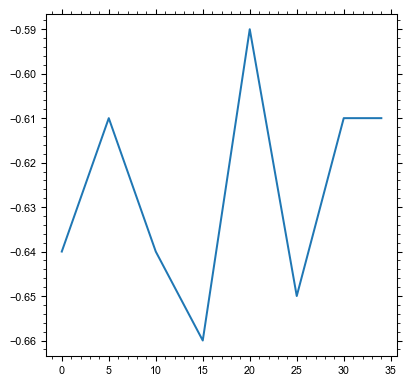

In [43]:
pl.plot((Lund_ERFari + Lund_ERFaci)[230:265])

In [44]:
sl_cmip = {}
se_cmip = {}
sl_cmip['CanESM5'],_,_,_,se_cmip['CanESM5'] = st.linregress(np.arange(35), CanESM5_aerforcing.loc[130:164,'erf'])
sl_cmip['E3SM'],_,_,_,se_cmip['E3SM'] = st.linregress(np.arange(35), E3SM_aerforcing.loc[110:144,'erf'])
sl_cmip['GFDL-CM4'],_,_,_,se_cmip['GFDL-CM4'] = st.linregress(np.arange(35), GFDL_aerforcing.loc[130:164,'erf'])
sl_cmip['GFDL-ESM4'],_,_,_,se_cmip['GFDL-ESM4'] = st.linregress(np.arange(35), GFDLESM_aerforcing.loc[130:164,'erf'])
sl_cmip['GISS-E2-1-G'],_,_,_,se_cmip['GISS-E2-1-G'] = st.linregress(np.arange(35), GISS_aerforcing.loc[130:164,'erf'])
sl_cmip['HadGEM3-GC31-LL'],_,_,_,se_cmip['HadGEM3-GC31-LL'] = st.linregress(np.arange(35), HadGEM3_aerforcing.loc[130:164,'erf'])
sl_cmip['IPSL-CM6A-LR'],_,_,_,se_cmip['IPSL-CM6A-LR'] = st.linregress(np.arange(35), IPSL_aerforcing.loc[130:164,'erf'])
sl_cmip['MIROC6'],_,_,_,se_cmip['MIROC6'] = st.linregress(np.arange(35), MIROC6_aerforcing.loc[130:164,'erf'])
sl_cmip['MRI-ESM2-0'],_,_,_,se_cmip['MRI-ESM2-0'] = st.linregress(np.arange(35), MRI_aerforcing.loc[130:164, 'erf'])
sl_cmip['NorESM2-LM'],_,_,_,se_cmip['NorESM2-LM'] = st.linregress(np.arange(35), NorESM2_aerforcing.loc[130:164,'erf'])
sl_cmip['UKESM1-0-LL'],_,_,_,se_cmip['UKESM1-0-LL'] = st.linregress(np.arange(35), UKESM_aerforcing.loc[130:164,'erf'])
sl_cmip, se_cmip

({'CanESM5': 0.006517598646765829,
  'E3SM': 0.006892768855495043,
  'GFDL-CM4': 0.007782870814745554,
  'GFDL-ESM4': 0.003704431162657955,
  'GISS-E2-1-G': -0.0026189997649882176,
  'HadGEM3-GC31-LL': 0.00656898272581882,
  'IPSL-CM6A-LR': -0.002968048960013907,
  'MIROC6': -0.0011194016074014572,
  'MRI-ESM2-0': -0.002356568087708795,
  'NorESM2-LM': 0.006366685684939967,
  'UKESM1-0-LL': 0.015152011105059702},
 {'CanESM5': 0.0013864222844739572,
  'E3SM': 0.0029135373528848757,
  'GFDL-CM4': 0.00222706560971168,
  'GFDL-ESM4': 0.0035462862899780507,
  'GISS-E2-1-G': 0.0026184408799552177,
  'HadGEM3-GC31-LL': 0.0016897530883233335,
  'IPSL-CM6A-LR': 0.002870041645082006,
  'MIROC6': 0.0016783372267876971,
  'MRI-ESM2-0': 0.004698203950958217,
  'NorESM2-LM': 0.002915137268739768,
  'UKESM1-0-LL': 0.004180168819915306})

In [45]:
t90 = st.t.ppf(0.95, df=34)

In [46]:
def weighted_percentile(a, w, q):
    if isinstance(q, (list, tuple, np.ndarray)):
        result = []
        for iq in q:
            result.append(wquantiles.quantile(a, w, iq))
    else:
        result = wquantiles.quantile(a, w, q)
    return result

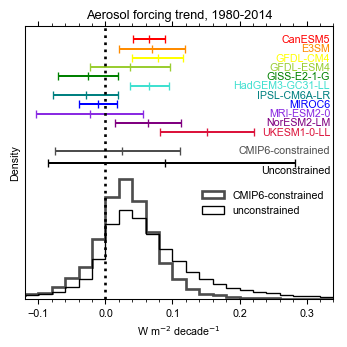

In [47]:
pl.figure(figsize=(9.3/2.54,9.3/2.54))
pl.hist(slopes * 10, weights=ks['multi']['CMIP6-constrained'], bins=np.arange(-0.6,0.5,0.02), density=True, color=colors['CMIP6-constrained'], lw=2, label='CMIP6-constrained', histtype='step');
pl.hist(slopes * 10, bins=np.arange(-0.6,0.5,0.02), density=True, color='k', label='unconstrained', histtype='step');
#for model in models:
#    pl.axvline(sl_cmip[model], color=colors[model], zorder=-1, label=model)
for i, model in enumerate(models):
    pl.plot(sl_cmip[model] * 10, 21-0.75*i, '|', color=colors[model])
    pl.errorbar(sl_cmip[model] * 10, 21-0.75*i, xerr=se_cmip[model]*t90*10, capsize=3, color=colors[model])
    #pl.text(se_cmip[model]*t90*10 + sl_cmip[model] * 10 + 0.01, 21-0.75*i, model, color=colors[model], ha='left', va='center')
    pl.text(0.335, 21-0.75*i, model, color=colors[model], ha='right', va='center')
pl.plot(np.sum(slopes * 10 * ks['multi']['CMIP6-constrained']), 12, '|', color=colors['CMIP6-constrained'])
#pl.plot(weighted_percentile(slopes * 10, ks['multi']['CMIP6-constrained'], .50), 12, '|', color=colors['CMIP6-constrained'])
pl.errorbar(
    weighted_percentile(slopes * 10, ks['multi']['CMIP6-constrained'], .50),
    12,
    xerr=np.array([
        weighted_percentile(slopes * 10, ks['multi']['CMIP6-constrained'], .50) - weighted_percentile(slopes * 10, ks['multi']['CMIP6-constrained'], .05),
        weighted_percentile(slopes * 10, ks['multi']['CMIP6-constrained'], .95) - weighted_percentile(slopes * 10, ks['multi']['CMIP6-constrained'], .50)
    ]).reshape((1,2)).T,
    capsize=3, color=colors['CMIP6-constrained']
)
pl.text(0.335, 12, 'CMIP6-constrained', color=colors['CMIP6-constrained'], ha='right', va='center')
pl.plot(np.mean(slopes * 10), 11, '|', color='k')
#pl.plot(np.percentile(slopes * 10, 50), 11, '|', color='k')
pl.errorbar(
    np.percentile(slopes * 10, 50),
    11,
    xerr=np.array([
        np.percentile(slopes * 10, 50) - np.percentile(slopes * 10, 5),
        np.percentile(slopes * 10, 95) - np.percentile(slopes * 10, 50)
    ]).reshape((1,2)).T,
    capsize=3, color='k'
)
pl.text(0.335, 10.4, 'Unconstrained', color='k', ha='right', va='center')
pl.title('Aerosol forcing trend, 1980-2014')
pl.xlabel('W m$^{-2}$ decade$^{-1}$')
pl.ylabel('Density')
pl.yticks([])
pl.axvline(0, ls=':', color='k', lw=2)
pl.legend(frameon=False, loc='lower right', bbox_to_anchor=[1, 0.27]);
pl.xlim(-0.12,0.34)
pl.tight_layout();
pl.savefig('../figures/figure7.png', dpi=300);
pl.savefig('../figures/figure7.pdf');

In [48]:
print(weighted_percentile(slopes * 10, ks['multi']['CMIP6-constrained'], [.05,.95]), np.sum(slopes * 10 * ks['multi']['CMIP6-constrained']))
print(np.percentile(slopes*10, (5,95)), np.mean(slopes*10))
for model in models:
    print(model, np.round((sl_cmip[model]-se_cmip[model]*t90)*10, 3), np.round(sl_cmip[model]*10, 3), np.round((sl_cmip[model]+se_cmip[model]*t90)*10, 3))

[-0.07463943360847243, 0.11187325270898836] 0.025271030885036683
[-0.08620322  0.28249911] 0.08809789869574185
CanESM5 0.042 0.065 0.089
E3SM 0.02 0.069 0.118
GFDL-CM4 0.04 0.078 0.115
GFDL-ESM4 -0.023 0.037 0.097
GISS-E2-1-G -0.07 -0.026 0.018
HadGEM3-GC31-LL 0.037 0.066 0.094
IPSL-CM6A-LR -0.078 -0.03 0.019
MIROC6 -0.04 -0.011 0.017
MRI-ESM2-0 -0.103 -0.024 0.056
NorESM2-LM 0.014 0.064 0.113
UKESM1-0-LL 0.081 0.152 0.222
